In [ ]:
!pip install transformers opencv-python einops torchvision accelerate bitsandbytes matplotlib

In [ ]:
!pip install git+https://github.com/facebookresearch/sam2.git

In [1]:
import os
import logging
from datetime import datetime
import warnings

import cv2
import requests
import re
import numpy as np
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

from transformers import (
    AutoModelForCausalLM,
    AutoProcessor,
    GenerationConfig,
    BitsAndBytesConfig,
)

# Suppress warnings
warnings.filterwarnings("ignore")


In [2]:
os.makedirs("Molmo_pts", exist_ok=True)

def read_image_url(image_url):
    response = requests.get(image_url)
    image_pil = Image.open(BytesIO(response.content))
    image_np = np.array(image_pil)
    image = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)  # Load the image using OpenCV

    return image


def read_image(path):
    image = cv2.imread(path)
    
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return rgb_image

In [3]:
exit_trigger = "quit()"

color_b = "\033[94m"
color_r = "\033[91m"
reset = "\033[0m" #Reset to default terminal color
image_url = ""

# image_url = "https://images.pexels.com/photos/29599636/pexels-photo-29599636/free-photo-of-woman-photographing-in-yellow-flower-field-in-vietnam.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1"

path = "input_images/dog.jpg"
img_path = os.path.join(os.getcwd(), path)

if image_url:
    ip_img = read_image_url(image_url)
else:
    ip_img = read_image(img_path)

In [4]:
model_id = "allenai/MolmoE-1B-0924" #allenai/Molmo-7B-D-0924 , allenai/MolmoE-1B-0924

quant_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_use_double_quant=False)



def load_model(model_id, quant_config: BitsAndBytesConfig = None, dtype="auto", device="cuda"):
    # Load the processor
    processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True, torch_dtype="auto", device_map=device)

    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        trust_remote_code=True,
        torch_dtype=dtype,
        device_map=device,
        quantization_config=quant_config,
    )

    return model, processor

model, processor = load_model(model_id, quant_config=quant_config, dtype="auto", device="cuda")

def molmo_answer(query_text, input_img):
    
        inputs = processor.process(images=input_img, text=query_text)
        # Move inputs to the correct device and create a batch of size 1
        inputs = {k: v.to(model.device).unsqueeze(0) for k, v in inputs.items()}

        # Generate output; maximum 500 new tokens; stop generation when <|endoftext|> is generated
        output = model.generate_from_batch(
        inputs, GenerationConfig(max_new_tokens=2048, stop_strings="<|endoftext|>"), tokenizer=processor.tokenizer
        )

        # Only get generated tokens; decode them to text
        generated_tokens = output[0, inputs["input_ids"].size(1) :]
        generated_text = processor.tokenizer.decode(generated_tokens, skip_special_tokens=True)

        return generated_text

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPTNeoXTokenizer'. 
The class this function is called from is 'GPT2TokenizerFast'.


In [5]:
def overlay_points_on_image(image, points, radius=5, color = (255,0,0)):
    """
    Overlay points and a label on the image.

    :param image: OpenCV Image object (BGR)
    :param points: List of points with coordinates [(x1, y1), (x2, y2), ...]
    :param text: Text to label the points (optional)
    :param radius: Radius of the circle used to mark the points (default: 5)
    :return: None
    """
    # Define the BGR color equivalent of the hex color #f3599e
    pink_color = (158, 89, 243)  # Color for the points (BGR format)

    
    for (x,y) in points:
         # Draw points as circles on the image
         
        outline = cv2.circle(image, (int(x), int(y)), radius=radius+1, color = pink_color, thickness=2, lineType=cv2.LINE_AA) 
        image_pt = cv2.circle(outline, (int(x), int(y)), radius=radius, color=color, thickness=-1, lineType=cv2.LINE_AA)  # BGR color format
    sav_image = image_pt.copy()
    image = cv2.cvtColor(sav_image, cv2.COLOR_BGR2RGB)
        
    cv2.imwrite("points_debug_circle_opencv.jpg", sav_image)

    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)     

In [6]:
def get_coords(image, generated_text):
    h, w,_ = image.shape

    if "</point" in generated_text:
        matches = re.findall(r'(?:x(?:\d*)="([\d.]+)"\s*y(?:\d*)="([\d.]+)")', generated_text)
    
        if len(matches) > 1:
            coordinates = [(int(float(x_val)/100*w), int(float(y_val)/100*h)) for x_val, y_val in matches]
        else:
            coordinates = [(int(float(x_val)/100*w), int(float(y_val)/100*h)) for x_val,y_val in matches]
        

    else:
        print("There are no points obtained from regex pattern")
       

    return coordinates

In [7]:
from sam2.sam2_image_predictor import SAM2ImagePredictor
import torch

sam_model_id = "facebook/sam2.1-hiera-large"



now = datetime.now()
current_time = now.strftime("%H_%M_%S")


os.makedirs("sam_molmo_outputs", exist_ok=True)


#------------------------------ SHOW MASK -------------------------------------------------         

def show_mask(mask, base_image, color=(1.0, 40/255, 50/255, 0.6), borders=True):
    """
    Returns an image with the mask overlaid on the base_image.
    
    Parameters:
    - mask: 2D numpy array of shape (H, W), where non-zero values indicate the mask.
    - base_image: 3D numpy array of shape (H, W, 3), the original image.
    - color: Tuple of (R, G, B, A), where A is the alpha transparency.
    - borders: Boolean indicating whether to draw contours around the mask.
    
    Returns:
    - blended: 3D numpy array of shape (H, W, 3), the image with mask overlay.
    """
    # Ensure mask is binary
    mask = (mask > 0).astype(np.uint8)

    # Dimensions
    h, w = mask.shape

    # Extract RGB and alpha components
    overlay_color = np.array(color[:3], dtype=np.float32)  # RGB, without opacity
    alpha = color[3] #opacity

    # Normalize base image to [0,1]
    base_image_float = base_image.astype(np.float32) / 255.0

    # Create an empty overlay image
    overlay = np.zeros_like(base_image_float)

    # Assign the overlay color to the masked regions
    # Using the 2D mask to index the first two dimensions
    overlay[mask == 1] = overlay_color

    # Blend the overlay with the base image only where mask is present
    blended = base_image_float.copy()
    blended[mask == 1] = (
        alpha * overlay[mask == 1] + (1 - alpha) * base_image_float[mask == 1]
    )

    # Convert back to [0,255] uint8
    blended = np.clip(blended * 255, 0, 255).astype(np.uint8)

    # If borders are requested, draw contours on the blended image
    if borders:
        
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # Draw contours in blue color with thickness 2
        cv2.drawContours(blended, contours, -1, (255, 0, 0), 2)  # BGR = (255,0,0) for blue contours

    return blended

# ----------------------------------------------------------------------------------------------------------------------

def show_masks(image, masks, scores, borders=True):
    
    """
    Overlays the top mask (based on highest score) on the image.

    :param image: Original image (BGR)
    :param masks: List or array of masks
    :param scores: List or array of scores corresponding to each mask
    :param borders: Whether to draw borders around the masks
    :return: Image with the top mask overlayed
    """
    
    sort_idxs = np.argsort(scores)[::-1] #descending order
    masks = masks[sort_idxs]
    scores = scores[sort_idxs]
    
    if len(masks) == 0:
        print("No masks found")
        return image
    
    top_mask = masks[sort_idxs][0]
    
    final_image = show_mask(top_mask, image, borders = True)


    return final_image

# -------------------------------- SAM --------------------------------------------------------

def segment(image, points, show_pts=True, sam_model_id="facebook/sam2.1-hiera-large"):
    
    points_cp = np.array(points)
    
    
    point_labels = np.ones(len(points_cp), dtype = np.uint8)
    
    predictor = SAM2ImagePredictor.from_pretrained(sam_model_id)

    with torch.inference_mode():
        predictor.set_image(image)
        
        masks,scores,logits = predictor.predict(
            point_coords=points_cp,
            point_labels=point_labels,
            multimask_output=False
        )
    
    
    
    sam_op_img = show_masks(image, masks,scores,borders=True)
  

    r = int(image.shape[0] * 0.007)
      
    if show_pts is not None:
        final_image = overlay_points_on_image(sam_op_img, points_cp, radius = r, color = (0,0,255, 0.6))
        
        dpi = plt.rcParams['figure.dpi']
        figsize = image.shape[1]/dpi, image.shape[0]/dpi
        plt.figure(figsize=figsize)
        plt.imshow(final_image)
        
        plt.axis('off')
        plt.tight_layout()
        plt.subplots_adjust(left=0, right=1, top = 1, bottom = 0)
        plt.savefig(f"sam_molmo_outputs/molmo_op_sam_pt_{current_time}.png", bbox_inches = 'tight', pad_inches = 0)
        plt.show()

************ Enter Your Input Query: *****************
Scaled points:  [(173, 62)]


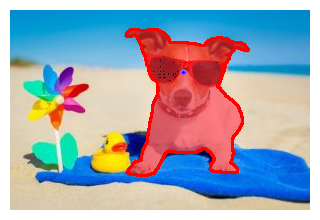

************ Enter Your Input Query: *****************


In [ ]:
while True:
    
    print(f"{color_b}************ Enter Your Input Query: *****************{reset}")
    
    input_query = input()
    
    

    
    generated_text = molmo_answer(query_text=input_query, input_img=ip_img) #pass to molmo  history + current query
    
    
    if "</point" in generated_text:

        points = get_coords(ip_img, generated_text)
        print("Scaled points: ", points)
        
  
        segment(ip_img, points, sam_model_id=sam_model_id)
        img_copy = ip_img.copy()
        
        only_pts_img = overlay_points_on_image(image = img_copy, points=points, color = (0,0,255), radius=4)
        
        now = datetime.now()
        current_time = now.strftime("%H_%M_%S")

        cv2.imwrite(f"Molmo_pts/molmo_pts_{current_time}.jpg", only_pts_img)
        
    
    
    if input_query == exit_trigger:
        print(f"{color_r}**************************Exiting Molmo Chat!***************************{reset}")
        break